In [1]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re
import mne
import json

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

In [2]:
def get_coverage_rates(f):
    df = pd.read_csv(f)
    cov = (df.prevalence >= df.pcurve_hdi_low) &\
        (df.prevalence <= df.pcurve_hdi_high)
    cov_rate_pcurve = cov.mean()
    cov = (df.prevalence >= df.binom_hdi_low) &\
        (df.prevalence <= df.binom_hdi_high)
    cov_rate_binom = cov.mean()
    return cov_rate_pcurve, cov_rate_binom

def get_hdi_width(f):
    df = pd.read_csv(f)
    width_pcurve = (df.pcurve_hdi_high - df.pcurve_hdi_low).to_numpy()
    width_binom = (df.binom_hdi_high - df.binom_hdi_low).to_numpy()
    return np.stack([width_pcurve, width_binom])

def get_expectation(f):
    df = pd.read_csv(f)
    mean_pcurve = df.pcurve_expectation.to_numpy()
    mean_binom = df.binom_expectation.to_numpy()
    return np.stack([mean_pcurve, mean_binom])

def get_map(f):
    df = pd.read_csv(f)
    mean_pcurve = df.pcurve_map.to_numpy()
    mean_binom = df.binom_map.to_numpy()
    return np.stack([mean_pcurve, mean_binom])

def plot_asymptotic(fs_high, fs_low, to_plot, axs):

    if to_plot == 'high power':
        fs = fs_high
        pow = pd.read_csv(fs_low[0]).prevalence.iloc[0]
        prev = pd.read_csv(fs_high[0]).prevalence.iloc[0]
    elif to_plot == 'low power':
        fs = fs_low
        prev = pd.read_csv(fs_low[0]).prevalence.iloc[0]
        pow = pd.read_csv(fs_high[0]).prevalence.iloc[0]
        

    cov_rates = [get_coverage_rates(f) for f in fs]
    cov_rates = np.array(cov_rates).T
    
    hdi_width = [get_hdi_width(f) for f in fs]
    hdi_width = np.stack(hdi_width, axis = 1)
    
    expectation = [get_expectation(f) for f in fs]
    expectation = np.stack(expectation, axis = 1)
    
    mpost = [get_map(f) for f in fs]
    mpost = np.stack(mpost, axis = 1)
    
    num_subs = np.array([n_subs(f) for f in fs])

    ax = axs[0]
    upper = np.quantile(expectation, .025, axis = -1)
    lower = np.quantile(expectation, .975, axis = -1)
    exp = np.mean(expectation, -1)
    ax.scatter(num_subs-.15, exp[0], color = 'firebrick', label = r'$p$-curve model')
    ax.vlines(num_subs-.15, lower[0], upper[0], color = 'firebrick')
    ax.scatter(num_subs+.15, exp[1], color = 'royalblue', label = 'binomial model')
    ax.vlines(num_subs+.15, lower[1], upper[1], color = 'royalblue')
    ax.axhline(prev, linestyle = '--', color = 'black', label = 'true prevalence')
    ax.axhline(pow, linestyle = 'dotted', color = 'black', label = 'average power')
    ax.set_ylim(0, 1)
    if to_plot == 'low power':
        ax.set_ylabel('posterior expectation')
        ax.legend(loc = 'lower right', framealpha = 1.)
    else:
        ax.set_yticks([])
    ax.set_xticks([])
    
    ax = axs[1]
    upper = np.quantile(hdi_width, .95, axis = -1)
    lower = np.quantile(hdi_width, .05, axis = -1)
    w = np.mean(hdi_width, -1)
    ax.scatter(num_subs-.15, w[0], color = 'firebrick')
    ax.scatter([], [], color = 'gray', label = 'mean 95% HDI width')
    ax.vlines(num_subs-.15, lower[0], upper[0], color = 'firebrick')
    ax.scatter(
        num_subs, 1 - cov_rates[0], 
        marker = 'x', color = 'firebrick', 
        #label = "false coverage rate"
    )
    ax.scatter(num_subs+.15, w[1], color = 'royalblue')
    ax.vlines(num_subs+.15, lower[1], upper[1], color = 'blue')
    ax.scatter(
        num_subs, 1 - cov_rates[1], 
        marker = 'x', color = 'royalblue', 
        #label = "false coverage rate"
    )
    ax.scatter([], [], color = 'gray', marker = 'x', label = 'false coverage rate')
    ax.axhline(np.abs(pow - prev), color = 'black', linestyle = 'dashdot', label = '|prevalence - power|')
    ax.axhline(.05, color = 'black')#, label = '5% rate')
    
    ax.set_ylim(0, 1)
    if to_plot == 'low power':
        ax.set_ylabel('proportion')
        ax.legend(loc = 'upper right')
    else:
        ax.set_yticks([])
    ax.set_xlabel('number of subjects')


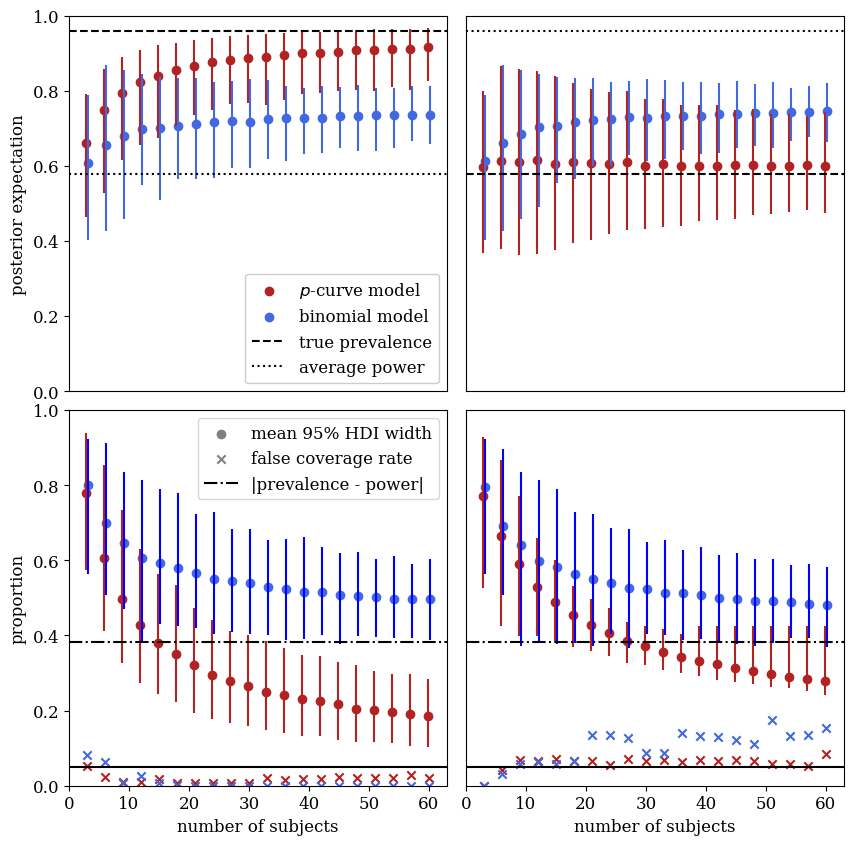

In [3]:
read_from = 'classification'
fs = [f for f in os.listdir(read_from) if '.csv' in f]
n_subs = lambda f: int(re.findall(r'subjects-(\w+)_', f)[0])
fs.sort(key = n_subs)
fs_high = [os.path.join(read_from, f) for f in fs if 'high' in f]
fs_low = [os.path.join(read_from, f) for f in fs if 'low' in f]

fig = plt.figure(figsize = (10, 10))
gs = gridspec.GridSpec(2, 2, wspace = .05, hspace = .05)
axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[1, 0])]
plot_asymptotic(fs_high, fs_low, 'low power', axs)
axs = [fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 1])]
plot_asymptotic(fs_high, fs_low, 'high power', axs)

if not os.path.exists('figures'):
    os.mkdir('figures')
fpath = os.path.join('figures', 'benchmark-classification.jpeg')
plt.savefig(fpath, dpi = 500, bbox_inches = 'tight')
plt.show()

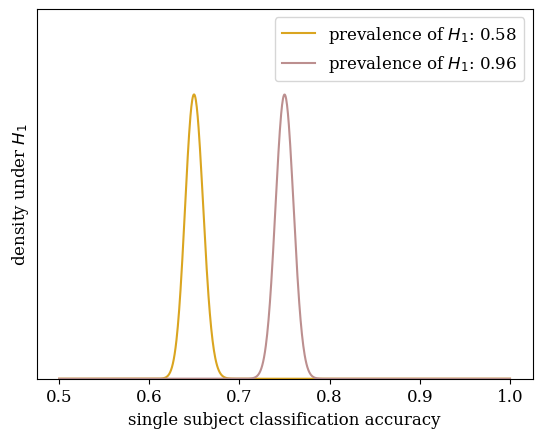

In [4]:
## visualize distribution of effect sizes used in above simulations
## of classification accuracy

from pymc.distributions.continuous import Beta
from scipy.stats import beta

def pdf_trunc(acc, p_mean):
    trunc_mean = (p_mean - .5) * 2
    a, b = Beta.get_alpha_beta(mu = trunc_mean, sigma = .02)
    return beta.pdf((acc - .5) * 2, a, b)

pow1 = pd.read_csv(fs_low[0]).prevalence.iloc[0]
pow2 = pd.read_csv(fs_high[0]).prevalence.iloc[0]

accs = np.linspace(.5, 1., 1000)
dens1 = pdf_trunc(accs, .65)
dens2 = pdf_trunc(accs, .75)
plt.ylim(None, np.max(dens1) * 1.3)
plt.plot(accs, dens1, color = 'goldenrod', label = r'prevalence of $H_1$: %.02f'%(pow2))
plt.plot(accs, dens2, color = 'rosybrown', label = r'prevalence of $H_1$: %.02f'%(pow1))
plt.legend()
plt.xlabel(r"single subject classification accuracy")
plt.gca().get_yaxis().set_ticks([])
plt.ylabel(r'density under $H_1$')
plt.show()

In [5]:
def load_prob(fs, manip, prob = 'prev', model = 'pcurve'):
    probs = []
    for fp in fs:
        with open(fp, 'r') as f:
            d = json.load(f)
        pr = d['increase_%s'%manip][model]['%sdiff_prob'%prob]
        probs.append(pr)
    return np.array(probs)

def load_pval(manip, read_from):
    fs = [f for f in os.listdir(read_from) if '.json' in f]
    seed = lambda f: int(re.findall(r'seed-(\w+)\.json', f)[0])
    fs.sort(key = seed)
    fs = [os.path.join(read_from, f) for f in fs]
    probs = []
    for fp in fs:
        with open(fp, 'r') as f:
            d = json.load(f)
        pr = d['increase_%s'%manip]['pval_group']
        probs.append(pr)
    return np.array(probs)

def get_power(manip, read_from):
    fs = [f for f in os.listdir(read_from) if '.json' in f]
    seed = lambda f: int(re.findall(r'seed-(\w+)\.json', f)[0])
    fs.sort(key = seed)
    fs = [os.path.join(read_from, f) for f in fs]
    rejs = []
    for fp in fs:
        with open(fp, 'r') as f:
            d = json.load(f)
        r = d[manip]['frac_H1_rej']
        rejs.append(r)
    return np.array(rejs).mean()


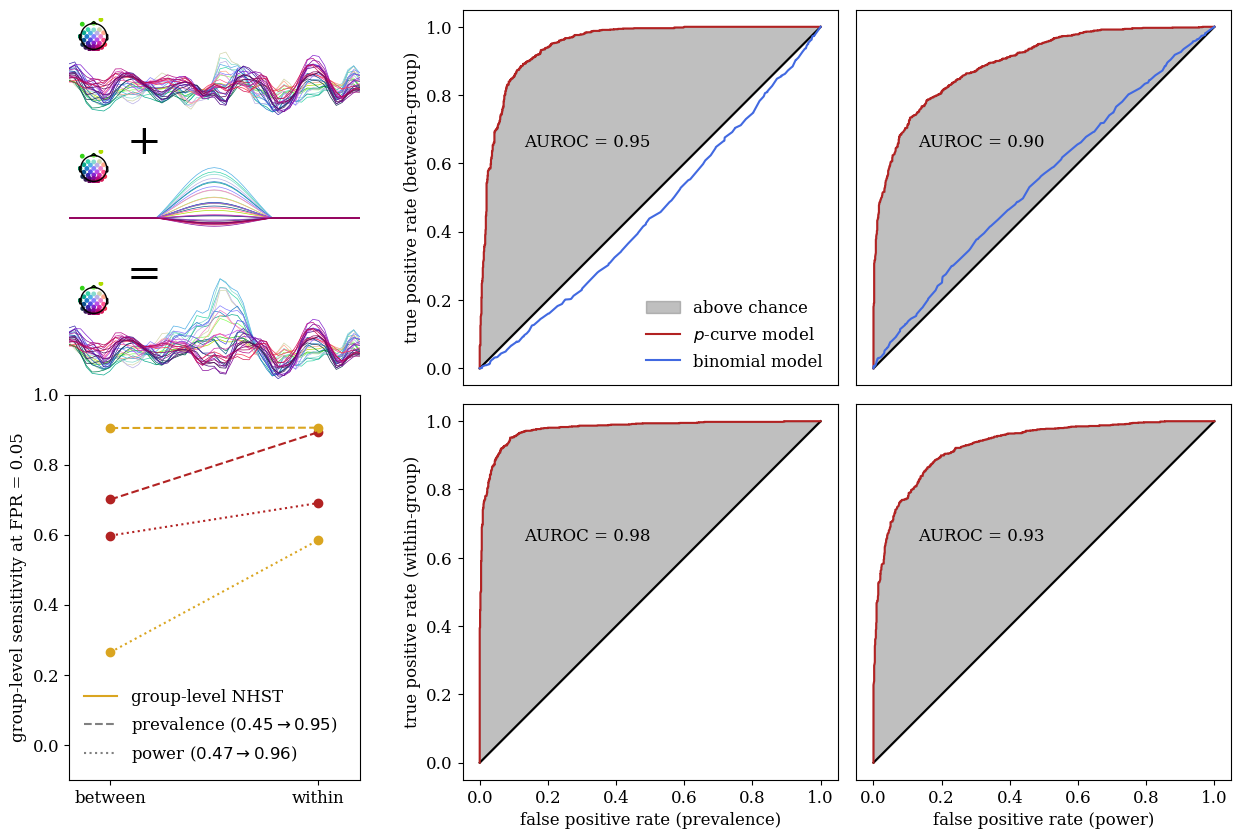

In [6]:
def plot_erp_illustration(axs):

    np.random.seed(0)
    from simulate_eeg_between import load_eeg, make_epochs
    raw, erp = load_eeg()
    np.random.seed(0)
    ax = axs[2]
    epochs = make_epochs(raw, erp, 1, seed = 5)
    evo = epochs['2'].average()
    evo.nave = None
    evo.plot(axes = ax, show = False)
    ax.axis('off')
    ax.set_title(None)
    ylim = ax.get_ylim()
    
    np.random.seed(0)
    ax = axs[0]
    epochs = make_epochs(raw, erp, 0, seed = 5)
    evo = epochs['2'].average()
    evo.nave = None
    evo.plot(axes = ax, show = False)
    ax.axis('off')
    ax.set_title(None)
    ax.set_ylim(ylim)
    ax.text(epochs.times.mean() - .15, 2*ylim[0], '+', size = 30)
    
    ax = axs[1]
    erp_evo = mne.EvokedArray(erp, raw.info)
    erp_evo = erp_evo.drop_channels(["T8"])
    erp_evo.nave = None
    erp_evo.plot(axes = ax, show = False)
    ax.axis('off')
    ax.set_title(None)
    ax.set_ylim(ylim)
    ax.text(epochs.times.mean() - .15, 2*ylim[0], '=', size = 30)


def plot_auroc(read_from, to_plot, ax, legend = False, xlabel = True, ylabel = True):
    from sklearn.metrics import roc_curve, roc_auc_score

    fs = [f for f in os.listdir(read_from) if '.json' in f]
    seed = lambda f: int(re.findall(r'seed-(\w+)\.json', f)[0])
    fs.sort(key = seed)
    fs = [os.path.join(read_from, f) for f in fs]

    probpow = load_prob(fs, 'pow', to_plot, 'pcurve') 
    probprev = load_prob(fs, 'prev', to_plot, 'pcurve') 
    y = np.zeros(probprev.size * 2)
    if to_plot == 'prev':
        y[probprev.size:] = 1
    else:
        y[:probprev.size] = 1
    yhat = np.concatenate([probpow, probprev])

    auroc = roc_auc_score(y, yhat)
    
    fpr, tpr, thresholds = roc_curve(y, yhat)
    ax.fill_between(fpr, fpr, tpr, color = 'grey', alpha = .5, label = 'above chance')
    ax.plot((0, 1), (0, 1), color = 'black')
    ax.plot(fpr, tpr, color = 'firebrick', label = r'$p$-curve model')
    if xlabel:
        if to_plot == 'prev':
            ax.set_xlabel('false positive rate (prevalence)')
        else:
            ax.set_xlabel('false positive rate (power)')
    else:
        ax.set_xticks([])
    if ylabel:
        ax.set_ylabel('true positive rate (%s-group)'%read_from)
    else:
        ax.set_yticks([])
    ax.text(.13, .65, 'AUROC = %.02f'%auroc)
    
    try:
        probpow = load_prob(fs, 'pow', 'prev', 'binom') 
        probprev = load_prob(fs, 'prev', 'prev', 'binom') 
        yhat = np.concatenate([probpow, probprev])
        _fpr, _tpr, _ = roc_curve(y, yhat)
        ax.plot(_fpr, _tpr, color = 'royalblue', label = 'binomial model')
    except:
        pass
    thres = thresholds[np.where(fpr >= .05)[0][0]]
    tpr_at_fpr = tpr[fpr <= .05][-1]
    if legend:
        ax.legend(framealpha = 0.)
    return tpr_at_fpr, thres

fig = plt.figure(figsize = (15, 10))

gs = gridspec.GridSpec(6, 4, wspace = 0., hspace = .2)
axs = [fig.add_subplot(gs[i, 0]) for i in range(3)]
plot_erp_illustration(axs)


gs = gridspec.GridSpec(2, 3, wspace = .05, hspace = .05)
axs = [fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2]), 
       fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2])]
tpr_bw_prev, _ = plot_auroc('between', 'prev', axs[0], legend = True, xlabel = False)
tpr_bw_pow, _ = plot_auroc('between', 'pow', axs[1], ylabel = False, xlabel = False)
tpr_wi_prev, _ = plot_auroc('within', 'prev', axs[2])
tpr_wi_pow, _ = plot_auroc('within', 'pow', axs[3], ylabel = False)

gs = gridspec.GridSpec(2, 3, wspace = .5, hspace = .0)
ax = fig.add_subplot(gs[1, 0])
ax.set_ylim(-.1, 1)
ax.set_xticks([0, 1], labels = ['between', 'within'])
ax.set_xlim(-.2, 1.2)
ax.set_ylabel('group-level sensitivity at FPR = 0.05')

ax.scatter([0, 1], [tpr_bw_prev, tpr_wi_prev], color = 'firebrick')
ax.plot([0, 1], [tpr_bw_prev, tpr_wi_prev], color = 'firebrick', linestyle = '--')

ax.scatter([0, 1], [tpr_bw_pow, tpr_wi_pow], color = 'firebrick')
ax.plot([0, 1], [tpr_bw_pow, tpr_wi_pow], color = 'firebrick', linestyle = 'dotted')

# p < 0.1 for a two-sided p-val is p < 0.05 for one-sided,
# so more comparable to the TPR-at-FPR we got from model
p_wi_prev = (load_pval('prev', 'within') <= .1).mean() 
p_bw_prev = (load_pval('prev', 'between') <= .1).mean() 
ax.scatter([0, 1], [p_bw_prev, p_wi_prev], color = 'goldenrod')
ax.plot([0, 1], [p_bw_prev, p_wi_prev], color = 'goldenrod', linestyle = '--')

p_wi_pow = (load_pval('pow', 'within') <= .1).mean()
p_bw_pow = (load_pval('pow', 'between') <= .1).mean()
ax.scatter([0, 1], [p_bw_pow, p_wi_pow], color = 'goldenrod')
ax.plot([0, 1], [p_bw_pow, p_wi_pow], color = 'goldenrod', linestyle = 'dotted')

ax.plot([], [], color = 'goldenrod', label = 'group-level NHST')
ax.plot([], [], linestyle = '--', color = 'grey', label = r'prevalence ($0.45 \rightarrow 0.95$)')
pow_low = get_power('baseline', 'between')
pow_high = get_power('increase_pow', 'between')
ax.plot([], [], linestyle = 'dotted', color = 'grey', label = r'power ($%.02f \rightarrow %.02f$)'%(pow_low, pow_high))
ax.legend(framealpha = 0.)

plt.savefig(os.path.join('figures', 'auroc.jpeg'), dpi = 500, bbox_inches = 'tight')
plt.show()

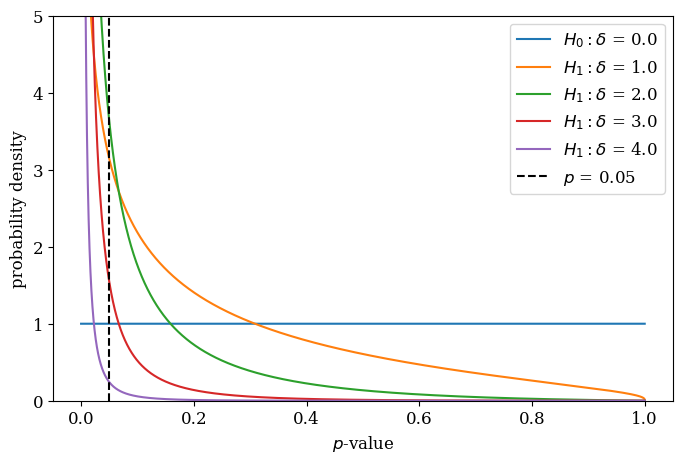

In [7]:
import sys
import os
import tempfile
cwd = os.getcwd()
pardir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(pardir)
from p2prev.pcurve import p_curve_lik as p_pdf

plt.figure(figsize = (8, 5))
ps = np.linspace(0, 1, 100000)[1:-1]
for d in (0, 1, 2, 3, 4):
    pdf = p_pdf(ps, d)
    H = 0 if d == 0 else 1
    plt.plot(ps, pdf, label = r'$H_%d: \delta$ = %.01f'%(H, d))
plt.ylim(0, 5)
plt.axvline(.05, linestyle = '--', color = 'black', label = r'$p$ = 0.05')
plt.legend()
plt.ylabel('probability density')
plt.xlabel(r'$p$-value')
plt.savefig(os.path.join('figures', 'pcurves.jpeg'), dpi = 500, bbox_inches = 'tight')
plt.show()

In [8]:
data_dir = 'heterogeneity'
fs = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if '.csv' in f]
seed = lambda f: int(re.findall(r'seed-(\w+)\.', f)[0])
fs.sort(key = seed)
dfs = [pd.read_csv(f) for f in fs]
df = pd.concat(dfs)
df.head()

,prevalence,pcurve_expectation,pcurve_hdi_low,pcurve_hdi_high,pcurve_map,binom_expectation,binom_hdi_low,binom_hdi_high,binom_map,sigma,seed
0,0.4,0.414516,0.158123,0.669784,0.395328,0.514909,0.169558,0.982652,0.491636,0.01,1
1,0.4,0.326522,0.030393,0.750735,0.239274,0.448380,0.065606,0.931534,0.415986,0.02,1
2,0.4,0.376186,0.081168,0.766467,0.322608,0.514909,0.169558,0.982652,0.491636,0.03,1
3,0.4,0.466505,0.205573,0.730020,0.461020,0.514909,0.169558,0.982652,0.491636,0.04,1
4,0.4,0.490299,0.230746,0.755704,0.476293,0.613902,0.311283,0.994782,0.609513,0.05,1


In [9]:
df['false_coverage'] = (df.prevalence > df.pcurve_hdi_high) | (df.prevalence < df.pcurve_hdi_low)
df.false_coverage = df.false_coverage.astype(float)
grouped = df.groupby('sigma').mean()
sigmas = grouped.index.to_numpy()
fcrs = grouped.false_coverage.to_numpy()
len(fcrs)

20

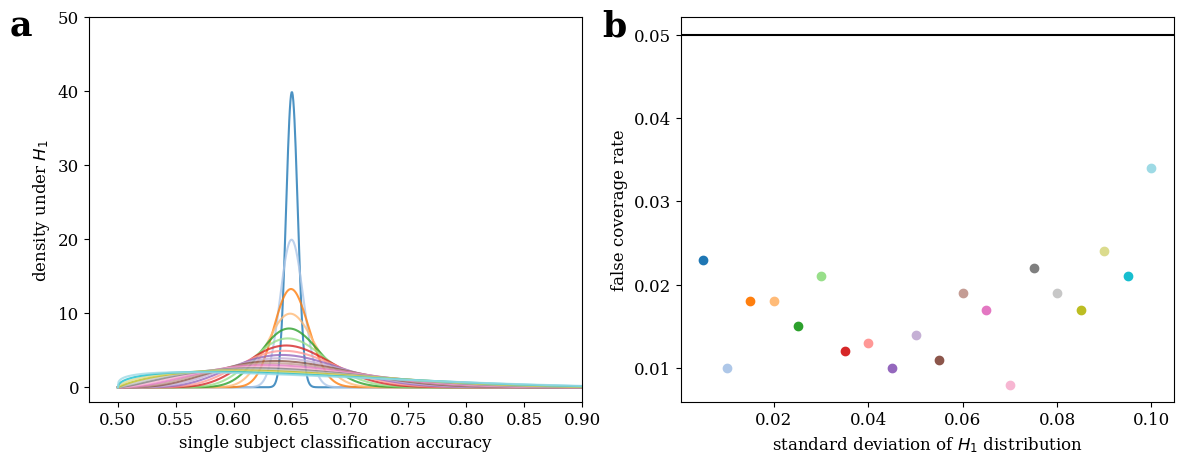

In [10]:
## visualize distribution of effect sizes used in above simulations
## of classification accuracy

from pymc.distributions.continuous import Beta
from scipy.stats import beta

def pdf_trunc(acc, p_mean, sigma):
    trunc_mean = (p_mean - .5) * 2
    a, b = Beta.get_alpha_beta(mu = trunc_mean, sigma = sigma)
    return beta.pdf((acc - .5) * 2, a, b)

def add_label(ax, label, x_offset = -.16, y_offset = -.05):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin + x_offset*xscale, ymax + yscale*y_offset, 
        label, size = 25, weight = 'bold'
    )

fig, axs = plt.subplots(1, 2, figsize = (14, 5))
accs = np.linspace(.5, 1., 1000)
for sigma, fcr, c in zip(sigmas, fcrs, plt.cm.tab20.colors):
    dens = pdf_trunc(accs, .65, sigma)
    axs[0].plot(accs, dens, label = '%.02f'%sigma, alpha = .8, color = c)
    axs[1].scatter(sigma/2, fcr, color = c)
axs[0].set_ylim(None, 50)
axs[0].set_xlim(None, .9)
axs[0].set_xlabel(r"single subject classification accuracy")
#plt.gca().get_yaxis().set_ticks([])
axs[0].set_ylabel(r'density under $H_1$')
axs[1].set_xlabel(r'standard deviation of $H_1$ distribution')
axs[1].set_ylabel('false coverage rate')
axs[1].axhline(.05, color = 'black')
add_label(axs[0], 'a')
add_label(axs[1], 'b')
plt.savefig(os.path.join('figures', 'heterogeneity.jpeg'), dpi = 500, bbox_inches = 'tight')
plt.show()